Today's mini-lab is an excercise in abstraction, in addition to parameter tuning and visualisation. The models below come from scientific computing and epidemiology, and are implemented as systems of differential equations. 

*Without a thorough background in mathematics, you will not be able to understand the details. This is a good thing since we can then focus on using the model instead of digging in to the details.*

# When zombies attack!

The excellent paper "*When zombies attack!: Mathematical modelling of an outbreak of zombie infection*" explains the dynamic disiase spread using a zombie apocalypse as the case study. We will use this paper to illustrate a model that is interpretable yet still requires more mathematics than required for the course to undersdtand in detail. During the lab, you will get aquainted with the models from the paper and make modifications to either fit the model to some contraints from data or try different zombie invasion mitigation strategies.

The setting will be the town of Uppsala in Sweden (for obvious reasons). The population of the town is ca 165000 (not the full muicipality, we're only interested in a contigous urban area). In the equations below, the formulation is slightly modified so that the sum of the compartments is the total population of Uppsala.

In [41]:
N = 165000         # Population of Uppsala

In [42]:
from scipy.integrate import odeint  # For working with systems of differential equations
import numpy as np                  # Math
import matplotlib.pyplot as plt     # Plotting
import ipywidgets                   # Interactivity

##  The basic model

The following system of equations is from part 2 in the paper. Zombias start waking up, one per late evening (as they do), and start roaming the town in search of fresh brains.

$\frac{dS}{dt} = − \frac{\beta Z}{N}S$

$\frac{dZ}{dt} = \frac{\beta Z}{N}S − \frac{\alpha Z}{N}S + min(1, R) - \delta Z$

$\frac{dR}{dt} = \frac{\alpha Z}{N}S − min(1, R) + \delta Z$

#### Constants

$\beta$: Compund zombie infection rate

$\alpha$: Compund zombie eradication rate

$\delta$: Inverse of the mean number of days zombies survive (hard coded as 2 weeks)

We will assume that the timescale is fairly short and set $\Pi=\delta=0$, as in the paper. The system of differential equations above already reflect this simplification.

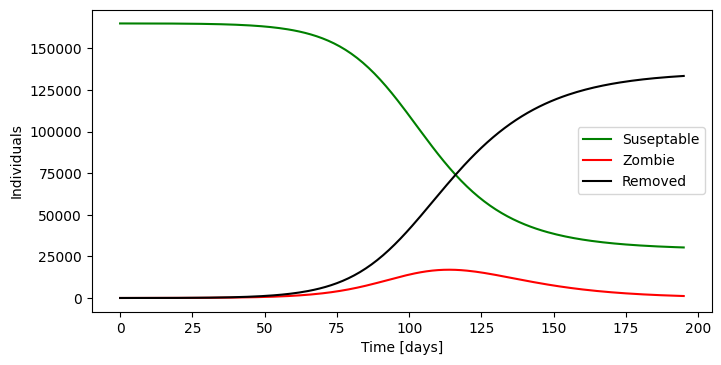

In [43]:
beta = .25  # Suseptable -> Zombie
alpha = .1  # Zombie -> Removed

def szr_model(y0, beta, alpha, runtime=28*7):
  """A SZR model
  
  runtime: int, runtime in days"""
  def szr_dydt(y, t, beta, alpha):
    S, Z, R = y
    delta = 1/14 # Zombies live for 2 weeks
    dydt = [- beta*S*Z/N,
            beta*S*Z/N + min(1, R) - alpha*S*Z/N - delta*Z,
            alpha*S*Z/N - min(1, R) + delta*Z]
    return dydt
  t = np.arange(runtime)
  res, debug_msg = odeint(szr_dydt, y0, t, args=(beta, alpha), full_output=True)
  return t, np.asarray(res).T, debug_msg

t, res, _ = szr_model(y0=np.asarray([N, 0, 10]), 
                beta=beta,
                alpha=alpha)

plt.figure(figsize=(8, 4), dpi=100)
plt.plot(t, res[0, :], 'g-', label="Suseptable")
plt.plot(t, res[1, :], 'r-', label="Zombie")
plt.plot(t, res[2, :], 'k-', label="Removed")
plt.legend()
plt.ylabel("Individuals")
plt.xlabel("Time [days]")
plt.show()

You can try different value using the following widget.

In [44]:
def szr_widget(beta, alpha):
  t, res, _ = szr_model(y0=np.asarray([N, 0, 10]), 
                  beta=beta,
                  alpha=alpha)

  plt.figure(figsize=(8, 4), dpi=100)
  plt.plot(t, res[0, :], 'g-', label="Suseptable")
  plt.plot(t, res[1, :], 'r-', label="Zombie")
  plt.plot(t, res[2, :], 'k-', label="Removed")
  plt.legend()
  plt.ylabel("Individuals")
  plt.xlabel("Time [days]")
  plt.show()

ipywidgets.interact(szr_widget,
                    beta=ipywidgets.FloatSlider(min=0, max=.5, step=0.01, value=.1, readout_format='.2f', description="S->Z (beta, prob. of infection)", style = {'description_width': 'initial'}, layout=ipywidgets.Layout(width='600px')),
                    alpha=ipywidgets.FloatSlider(min=0, max=.5, step=0.01, value=.1, readout_format='.2f', description="Z->R (alpha, prob. of eradication)", style = {'description_width': 'initial'}, layout=ipywidgets.Layout(width='600px')));

interactive(children=(FloatSlider(value=0.1, description='S->Z (beta, prob. of infection)', layout=Layout(widt…

What is the relation between the values of $\beta$ and $\alpha$? Run a grid search over them an plot using matplotlibs contour (or similar). All the code is already in the notebooks you have worked with.

## The Model with Latent Infection

$S' = -\beta SZ$

$E' = \beta SZ - \rho E$

$Z' = \rho E − \alpha SZ - \delta Z$

$R' = \alpha SZ + \delta Z$

#### Constants

$\beta$: Compund zombie infection rate

$\alpha$: Compund zombie erradication rate

$\delta$: Inverse of the mean number of days zombies survive

$\rho$: Inverse of the mean number of days from exposure to zombification

Again, ee will assume that the timescale is fairly short and set $\Pi=\delta=0$, as in the paper. We will also assume that zombies rise one per night. The new parameter $\rho$ controls the time from exposure to full sickness, i.e. incubation time. This parameter should be set to the inverse of the number of days before full infection, e.g. for a mena of 3 days $\rho=\frac{1}{3}$.

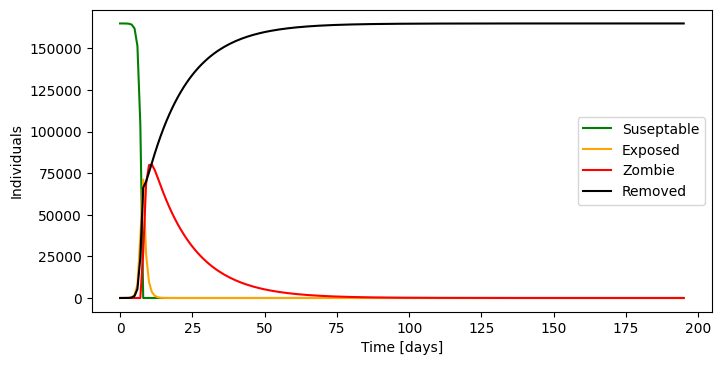

In [60]:
beta = .25    # Suseptable -> Zombie
alpha = .1    # Zombie -> Removed
rho_inv = 1   # Mean incubation days
delta_inv = 14 # Mean zombie lifespan

def sezr_model(y0, beta, alpha, rho_inv, delta_inv, runtime=28*7):
  def sezr_dydt(y, t, beta, alpha, rho_inv, delta_inv):
    S, E, Z, R = y
    dydt = [-beta*S*Z,
            beta*S*Z - E/rho_inv,
            E/rho_inv - alpha*S*Z - Z/delta_inv,
            alpha*S*Z + Z/delta_inv]
    return dydt
  t = np.arange(runtime)
  res, debug_msg = odeint(sezr_dydt, y0, t, args=(beta, alpha, rho_inv, delta_inv), full_output=True)
  return t, np.asarray(res).T, debug_msg

t, res, _ = sezr_model(y0=np.asarray([N, 1, 0, 0]), 
                beta=beta,
                alpha=alpha,
                delta_inv=delta_inv,
                rho_inv=rho_inv)

plt.figure(figsize=(8, 4), dpi=100)
plt.plot(t, res[0, :], 'g-', label="Suseptable")
plt.plot(t, res[1, :], color='orange', label="Exposed")
plt.plot(t, res[2, :], 'r-', label="Zombie")
plt.plot(t, res[3, :], 'k-', label="Removed")
plt.legend()
plt.ylabel("Individuals")
plt.xlabel("Time [days]")
plt.show()

In [46]:
def sezr_widget(beta, alpha, delta_inv, rho_inv):
  t, res, _ = sezr_model(y0=np.asarray([N, 0, 0, 10]), 
                  beta=beta,
                  alpha=alpha,
                  delta_inv=delta_inv,
                  rho_inv=rho_inv)
  plt.figure(figsize=(8, 4), dpi=100)
  plt.plot(t, res[0, :], 'g-', label="Suseptable")
  plt.plot(t, res[1, :], color='orange', label="Exposed")
  plt.plot(t, res[2, :], 'r-', label="Zombie")
  plt.plot(t, res[3, :], 'k-', label="Removed")
  plt.legend()
  plt.ylabel("Individuals")
  plt.xlabel("Time [days]")
  plt.show()

ipywidgets.interact(sezr_widget,
                    beta=ipywidgets.FloatSlider(min=0, max=.5, step=0.01, value=.1, readout_format='.2f', description="S->Z (beta, prob. of infection)", style = {'description_width': 'initial'}, layout=ipywidgets.Layout(width='600px')),
                    alpha=ipywidgets.FloatSlider(min=0, max=.5, step=0.01, value=.1, readout_format='.2f', description="Z->R (alpha, prob. of eradication)", style = {'description_width': 'initial'}, layout=ipywidgets.Layout(width='600px')),
                    rho_inv=ipywidgets.FloatSlider(min=0, max=21, step=0.5, value=3, readout_format='.2f', description="E->Z (mean incubation time in days)", style = {'description_width': 'initial'}, layout=ipywidgets.Layout(width='600px')),
                    delta_inv=ipywidgets.FloatSlider(min=0, max=21, step=0.5, value=3, readout_format='.2f', description="Z->R (Zombie mean life span in days)", style = {'description_width': 'initial'}, layout=ipywidgets.Layout(width='600px'))
                    );


interactive(children=(FloatSlider(value=0.1, description='S->Z (beta, prob. of infection)', layout=Layout(widt…

## A Model with vaccine